In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import requests
from io import BytesIO
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

import torchvision.transforms as transforms
import torchvision.models as models

In [13]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
imsize = 512 if torch.cuda.is_available else 256

print("CUDA is available" if torch.cuda.is_available else "CUDA is NOT available!")

CUDA is available


In [14]:
def load_image(img_path, shape=None, max_size=imsize):
  
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    
    loader = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
    ])
    
    image = loader(image).unsqueeze(0)
    
    return image

In [26]:
def show_image(tensor):
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    
    return image

In [27]:
content = load_image('images/space_needle.jpg').to(device)

style = load_image('images/ben_passmore.jpg', shape=content.shape[-2:]).to(device)

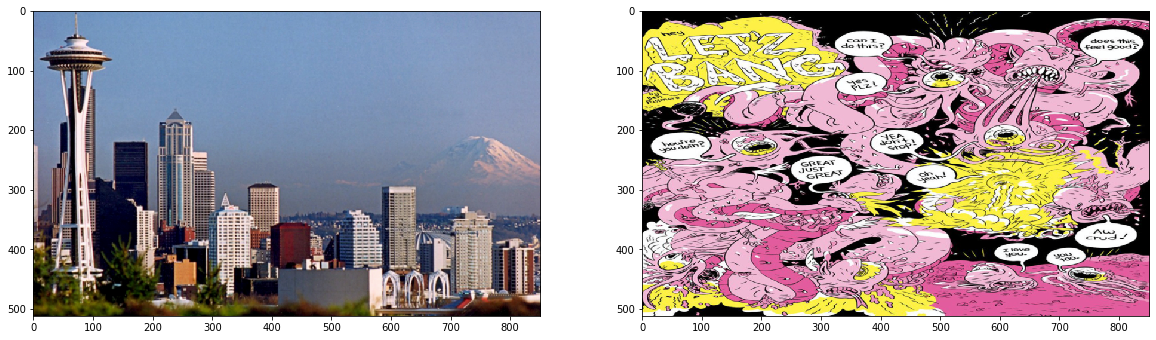

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(show_image(content))
ax2.imshow(show_image(style))

In [29]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [30]:
def get_features(image, model=vgg, layers=None):
    
    if layers == None:
        layers ={ '0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1' }
    
    features = {}
    x = image
    for name, layer in model._modules.items():
            x = layer(x)
            if name in layers:
                features[layers[name]] = x
    
    return features

def gram_matrix(tensor):
    
    _, d, h, w = tensor.size()
    
    tensor = tensor.view(d, h * w)
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [31]:
content_features = get_features(content)
style_features = get_features(style)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1   # alpha
style_weight = 1e6  # beta

In [32]:
import gc

for i in range(5):
    gc.collect()
    torch.cuda.empty_cache()

 total loss =  2453464.5


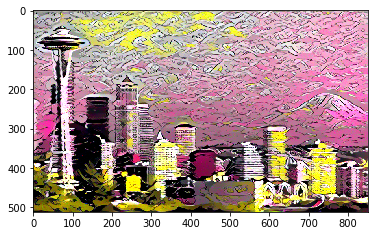

 total loss =  1254198.125


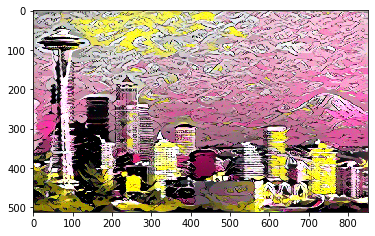

 total loss =  888970.5


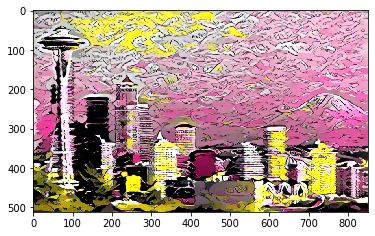

 total loss =  712037.75


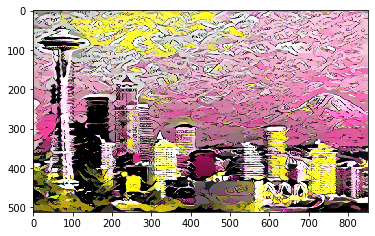

 total loss =  607297.0625


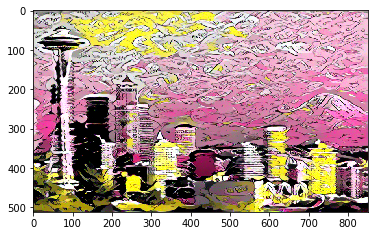

In [35]:
show_every = 800
steps = 4000

losses = {'content': [],
          'style' : [],
          'total' : []
         }

optimizer = optim.Adam([target], lr=0.003)

for i in range(1, steps+1):
    
    target_features = get_features(target)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_loss = 0
    
    for layer in style_weights:
        
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        
        _, d, h, w = target_feature.shape
        
        style_gram = style_grams[layer]
        
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
#     losses['content'].append(content_loss.item())
#     losses['style'].append(style_loss.item())
#     losses['total'].append(total_loss.item())
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if i % show_every == 0:
        print(' total loss = ', total_loss.item())
        plt.imshow(show_image(target))
        plt.show()